In [ ]:
from datasets import load_dataset

docci = load_dataset("google/docci", trust_remote_code=True)

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def collate_fn(batch):
    return clip_processor(images=[b["image"] for b in batch], return_tensors="pt")


dataloader = DataLoader(
    docci["train"],
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
)
features_tensors = []

for batch in tqdm(dataloader):
    batch_device = {k: v.to(clip_model.device) for k, v in batch.items()}
    with torch.no_grad():
        image_features = clip_model.get_image_features(**batch_device)
        features_tensors.append(image_features)

features_tensors = torch.cat(features_tensors)
out = features_tensors.cpu()
# normalize the image features
out = F.normalize(out, p=2, dim=1)
torch.save(out, "feats/docci_train_img_clip_features.pt")

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


def collate_fn_text(batch):
    return clip_processor(
        text=[b["description"] for b in batch],
        return_tensors="pt",
        padding=True,
        truncation=True,
    )


dataloader = DataLoader(
    docci["train"],
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn_text,
)
features_tensors = []
for batch in tqdm(dataloader):
    batch_device = {k: v.to(clip_model.device) for k, v in batch.items()}
    with torch.no_grad():
        text_features = clip_model.get_text_features(
            input_ids=batch_device["input_ids"]
        )
        features_tensors.append(text_features)

features_tensors = torch.cat(features_tensors)
out = features_tensors.cpu()
# normalize the image features
out = F.normalize(out, p=2, dim=1)
torch.save(out, "feats/docci_train_text_clip_features.pt")

# Load features from the dataset and sample example pairs from docci

In [2]:
import torch

out = torch.load("feats/docci_train_img_clip_features.pt")
img_sim_matrix = out @ out.T
# mask diagonal
mask = torch.eye(img_sim_matrix.shape[0], dtype=bool)
img_sim_matrix[mask] = 0

out = torch.load("feats/docci_train_text_clip_features.pt")
text_sim_matrix = out @ out.T
# mask diagonal
mask = torch.eye(text_sim_matrix.shape[0], dtype=bool)
text_sim_matrix[mask] = 0

In [3]:
import random

seen_idxs = set()

pair_dataset = []

ranges = [(0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]

N = 1000
while len(pair_dataset) < N:
    # random_idx = random.randint(0, len(docci["train"]) - 1)
    random_idx = random.randint(0, len(docci["train"]) - 1)
    random_range = random.choice(ranges)
    if random_idx in seen_idxs:
        continue

    # find all the indexes that are in the range
    indexes = torch.where(
        (img_sim_matrix[random_idx] >= random_range[0])
        & (img_sim_matrix[random_idx] <= random_range[1])
    )[0]
    if len(indexes) == 0:
        continue

    indexes = list(set(indexes.tolist()) - seen_idxs)
    if len(indexes) == 0:
        continue
    second_idx = random.choice(indexes)

    seen_idxs.add(random_idx)
    seen_idxs.add(second_idx)

    pair_dataset.append(
        (
            random_idx,
            second_idx,
            img_sim_matrix[random_idx][second_idx].item(),
            text_sim_matrix[random_idx][second_idx].item(),
            f"{random_range[0]} - {random_range[1]}",
        )
    )

In [4]:
import pandas as pd

df = pd.DataFrame(
    pair_dataset, columns=["idx1", "idx2", "img_similarity", "desc_similarity", "range"]
)
df["id"] = df["idx1"].astype(str) + "_" + df["idx2"].astype(str)

# subsample 25 from each range
df = (
    df.groupby("range")
    .apply(lambda x: x.sample(25, replace=False))
    .reset_index(drop=True)
)
df.sort_values("img_similarity", ascending=False, inplace=True)
assert df["id"].nunique() == len(df)
assert df["idx1"].nunique() == len(df)
assert df["idx2"].nunique() == len(df)
assert len(df) == 100

/var/folders/v9/d_dqlnbx7vl__wmp0ymbq2m80000gn/T/ipykernel_82875/600490753.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(25, replace=False))


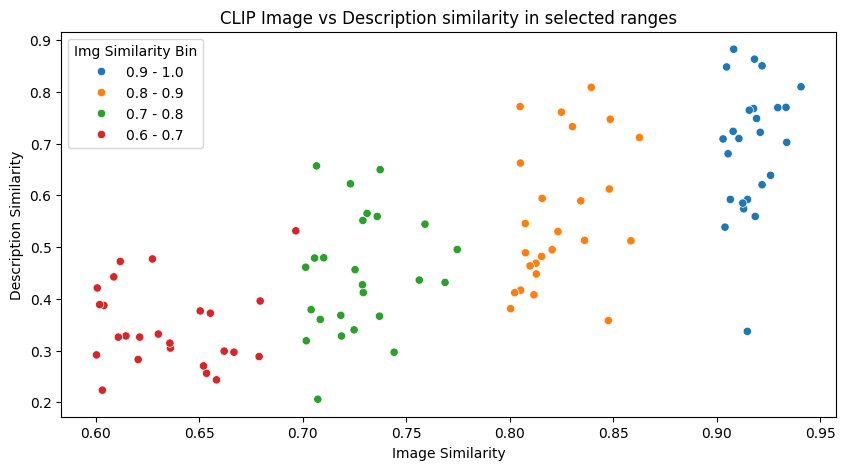

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# plot across the ranges
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x="img_similarity", y="desc_similarity", hue="range")
plt.title("CLIP Image vs Description similarity in selected ranges")
plt.legend(title="Img Similarity Bin")
plt.xlabel("Image Similarity")
plt.ylabel("Description Similarity")
# save plot
plt.savefig("plots/clip_similarity.png")
plt.show()

In [6]:
# save the dataset as list of jsons
import json

for i, row in df.iterrows():
    idx1 = row["idx1"]
    idx2 = row["idx2"]

    image1 = docci["train"][idx1]["image"]
    image2 = docci["train"][idx2]["image"]

    # save to data/imgs
    image1.save(f"data/imgs/{i}_0.jpg")
    image2.save(f"data/imgs/{i}_1.jpg")
    example_dict = {
        "id": i,
        "docci_idx_0": idx1,
        "docci_idx_1": idx2,
        "img_pair_similarity": row["img_similarity"],
        "desc_pair_similarity": row["desc_similarity"],
        "description_0": docci["train"][idx1]["description"],
        "description_1": docci["train"][idx2]["description"],
    }
    with open(f"data/{i:3d}.json", "w") as f:
        json.dump(example_dict, f)